In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import sys
sys.path.append('custom_modules')

import Data_processing as dp

from IPython.display import display
from matplotlib import ticker
from pathlib import Path
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Reshape, Input, Dense, Flatten, Conv2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, concatenate, BatchNormalization

### Константы для путей к файлам

In [2]:
# Пути к обработанным данным
# Пути к X части выборки с массивами в каждой ячейке
path_to_array_like_X_data = ('data/Prepared data/Run1/X_data_array_like.xlsx',
                             'data/Prepared data/Run2/X_data_array_like.xlsx')
# Пути к Y части выборки
path_to_Y_data = ('data/Prepared data/Run1/Y_data(binary_classification).xlsx', 
                  'data/Prepared data/Run2/Y_data(binary_classification).xlsx') 


### Константы для обработки данных

In [3]:
PREP_image_size = 16
PREP_crop_step = 4

In [4]:
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

# Подготовка данных

In [5]:
# загрузка данных из файлов
X_dict = dict()
Y_dict = dict()

for i,x_data_path,y_data_path in zip(range(len(path_to_array_like_X_data)),
                                     path_to_array_like_X_data, 
                                     path_to_Y_data):
    
    x_temp = dp.get_array_like_X_df(x_data_path)
    y_temp = dp.get_Y_df(y_data_path)
    
    X_dict[f'run{i+1}'] = {'df': x_temp}
    Y_dict[f'run{i+1}'] = {'df': y_temp}

In [6]:
print('Загружены данные для X выборки из файлов: ', X_dict.keys())
print('Загружены данные для Y выборки из файлов: ', Y_dict.keys())

Загружены данные для X выборки из файлов:  dict_keys(['run1', 'run2'])
Загружены данные для Y выборки из файлов:  dict_keys(['run1', 'run2'])


In [7]:
# добавление строк в датафреймы
for key in X_dict.keys():
    X_dict[key]['df'] = dp.reshape_df_for_future_crops(X_dict[key]['df'], PREP_image_size, PREP_crop_step)
    Y_dict[key]['df'] = dp.reshape_df_for_future_crops(Y_dict[key]['df'], PREP_image_size, PREP_crop_step) 
       

||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (115, 400)
Crop windows height/width:  16
Crop windows step across rows and cols:  4
New df shape:  (116, 400)
||||||||||||||||||

||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (115, 400)
Crop windows height/width:  16
Crop windows step across rows and cols:  4
New df shape:  (116, 400)
||||||||||||||||||

||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (119, 400)
Crop windows height/width:  16
Crop windows step across rows and cols:  4
New df shape:  (120, 400)
||||||||||||||||||

||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (119, 400)
Crop windows height/width:  16
Crop windows step across rows and cols:  4
New df shape:  (120, 400)
||||||||||||||||||



In [8]:
# запишем в словарь numpy array полученные из df
#step = 20
for i,key in zip(range(len(X_dict.keys())),X_dict.keys()):
    print(f"||||||||||||||step {i+1}||||||||||||||||")
    x_time_temp, x_amp_temp = dp.reshape_X_df_to_image_like_numpy(X_dict[key]['df'], PREP_image_size, PREP_crop_step)
    
    X_dict[key]['X_time_all'] = x_time_temp
    X_dict[key]['X_amp_all'] = x_amp_temp
    
    y_temp = dp.reshape_Y_df_to_image_like_numpy(Y_dict[key]['df'], PREP_image_size, PREP_crop_step)
    
    Y_dict[key]['Y_all'] = y_temp 
    print('\n')
     

||||||||||||||step 1||||||||||||||||
||||||||||||||||||
X df reshaping to 4D
Original df size:  (116, 400)
Crop windows height/width:  16
New X_time shape:  (2522, 16, 16, 32)
New X_amp shape:  (2522, 16, 16, 32)
||||||||||||||||||

||||||||||||||||||
Y df reshaping to 3D
Original df size:  (116, 400)
Crop windows height/width:  16
New numpy shape:  (2522, 16, 16, 1)
||||||||||||||||||



||||||||||||||step 2||||||||||||||||
||||||||||||||||||
X df reshaping to 4D
Original df size:  (120, 400)
Crop windows height/width:  16
New X_time shape:  (2619, 16, 16, 32)
New X_amp shape:  (2619, 16, 16, 32)
||||||||||||||||||

||||||||||||||||||
Y df reshaping to 3D
Original df size:  (120, 400)
Crop windows height/width:  16
New numpy shape:  (2619, 16, 16, 1)
||||||||||||||||||





In [9]:
print('X данные считаны для файлов: ',X_dict.keys())
for key in X_dict.keys():
    print('Для файла', key, 'считаны такие данные: ', X_dict[key].keys())
    
print('\nY данные считаны для файлов: ',Y_dict.keys())
for key in Y_dict.keys():
    print('Для файла', key, 'считаны такие данные: ', Y_dict[key].keys())

X данные считаны для файлов:  dict_keys(['run1', 'run2'])
Для файла run1 считаны такие данные:  dict_keys(['df', 'X_time_all', 'X_amp_all'])
Для файла run2 считаны такие данные:  dict_keys(['df', 'X_time_all', 'X_amp_all'])

Y данные считаны для файлов:  dict_keys(['run1', 'run2'])
Для файла run1 считаны такие данные:  dict_keys(['df', 'Y_all'])
Для файла run2 считаны такие данные:  dict_keys(['df', 'Y_all'])


In [10]:
# обработка данных
for key in X_dict.keys():
    print('||||||||||||||||||')
    print('Файл: ', key)
    
    (X_time_def,X_time_non_def), \
    (X_amp_def,X_amp_non_def), \
    (Y_def,Y_non_def) = dp.preprocess_data(X_dict[key]['X_time_all'], 
                                        X_dict[key]['X_amp_all'], 
                                        Y_dict[key]['Y_all'],
                                        PREP_image_size)
    
    X_dict[key]['X_time_def'] = X_time_def
    X_dict[key]['X_time_non_def'] = X_time_non_def
    
    X_dict[key]['X_amp_def'] = X_amp_def
    X_dict[key]['X_amp_non_def'] = X_amp_non_def
    
    Y_dict[key]['Y_def'] = Y_def
    Y_dict[key]['Y_non_def'] = Y_non_def

||||||||||||||||||
Файл:  run1
||||||||||||||||||
Data preprocessing
Orig X_time_arr shape:  (2522, 16, 16, 32)
Orig X_amp_arr shape:  (2522, 16, 16, 32)
Orig Y_arr shape:  (2522, 16, 16, 1)
||||||||||||||||||
Data standartization
X_time_max: 44.5
X_amp_max: 62.992
X_time_max after standartization: 1.0
X_time_min after standartization: 0.0
X_amp_max after standartization: 1.0
X_amp_min after standartization: -0.983743967487935
||||||||||||||||||

||||||||||||||||||
Data with and witout defects splitting
||||||||||||||||||
Defects nums calculating
Для карт высотой и шириной в 16
и общим кличеством: 2522
дефекты присутствуеют на 290 картах
||||||||||||||||||

X_time_arr_def shape:  (290, 16, 16, 32)
X_time_arr_non_def shape:  (2232, 16, 16, 32)
X_amp_arr_def shape:  (290, 16, 16, 32)
X_amp_arr_non_def shape:  (2232, 16, 16, 32)
Y_arr_def shape:  (290, 16, 16, 1)
Y_arr_non_def shape:  (2232, 16, 16, 1)
||||||||||||||||||

||||||||||||||||||

||||||||||||||||||
Файл:  run2
||||||||||||||||

In [11]:
print('X данные считаны для файлов: ',X_dict.keys())
for key in X_dict.keys():
    print('Для файла', key, 'считаны такие данные: ', X_dict[key].keys())
    
print('\nY данные считаны для файлов: ',Y_dict.keys())
for key in Y_dict.keys():
    print('Для файла', key, 'считаны такие данные: ', Y_dict[key].keys())

X данные считаны для файлов:  dict_keys(['run1', 'run2'])
Для файла run1 считаны такие данные:  dict_keys(['df', 'X_time_all', 'X_amp_all', 'X_time_def', 'X_time_non_def', 'X_amp_def', 'X_amp_non_def'])
Для файла run2 считаны такие данные:  dict_keys(['df', 'X_time_all', 'X_amp_all', 'X_time_def', 'X_time_non_def', 'X_amp_def', 'X_amp_non_def'])

Y данные считаны для файлов:  dict_keys(['run1', 'run2'])
Для файла run1 считаны такие данные:  dict_keys(['df', 'Y_all', 'Y_def', 'Y_non_def'])
Для файла run2 считаны такие данные:  dict_keys(['df', 'Y_all', 'Y_def', 'Y_non_def'])


In [12]:
# аугментация данных
X_time_def_1, X_amp_def_1, Y_def_1 = dp.augment_data(X_dict['run1']['X_time_def'], 
                                      X_dict['run1']['X_amp_def'],
                                      Y_dict['run1']['Y_def'])

X_time_def_2, X_amp_def_2, Y_def_2 = dp.augment_data(X_dict['run2']['X_time_def'],
                                      X_dict['run2']['X_amp_def'],
                                      Y_dict['run2']['Y_def'])

||||||||||||||||||
Data augmentation
Orig X_time_arr shape:  (290, 16, 16, 32)
Orig X_amp_arr shape:  (290, 16, 16, 32)
Orig Y_arr shape:  (290, 16, 16, 1)
||||||||||||
After 4 steps of 90 degree rotate
X_time_arr shape:  (1160, 16, 16, 32)
X_amp_arr shape:  (1160, 16, 16, 32)
Y_arr shape:  (1160, 16, 16, 1)
||||||||||||
After horizontal full mirroring
X_time_arr shape:  (2320, 16, 16, 32)
X_amp_arr shape:  (2320, 16, 16, 32)
Y_arr shape:  (2320, 16, 16, 1)
||||||||||||
After vertical full mirroring
X_time_arr shape:  (4640, 16, 16, 32)
X_amp_arr shape:  (4640, 16, 16, 32)
Y_arr shape:  (4640, 16, 16, 1)
||||||||||||
After vertical half shifting
X_time_arr shape:  (9280, 16, 16, 32)
X_amp_arr shape:  (9280, 16, 16, 32)
Y_arr shape:  (9280, 16, 16, 1)
||||||||||||
After horizontal half shifting
X_time_arr shape:  (18560, 16, 16, 32)
X_amp_arr shape:  (18560, 16, 16, 32)
Y_arr shape:  (18560, 16, 16, 1)
||||||||||||||||||

||||||||||||||||||
Data augmentation
Orig X_time_arr shape:  (278

In [13]:
test_data_percent = 0.4
val_data_percent = 0.1

X_time_def_tuple_1,\
X_amp_def_tuple_1,\
Y_def_tuple_1 = dp.split_data_to_train_test_val_datasets(X_time_def_1, 
                                                      X_amp_def_1, 
                                                      Y_def_1, 
                                                      test_data_percent, 
                                                      val_data_percent)
    
X_time_def_tuple_2, \
X_amp_def_tuple_2, \
Y_def_tuple_2 = dp.split_data_to_train_test_val_datasets(X_time_def_2, 
                                                      X_amp_def_2, 
                                                      Y_def_2, 
                                                      test_data_percent, 
                                                      val_data_percent)

''' X_time_non_def_tuple_1, \
X_amp_non_def_tuple_1, \
Y_non_def_tuple_1 = dp.split_data_to_train_test_val_datasets(X_dict['run1']['X_time_non_def'], 
                                                          X_dict['run1']['X_amp_non_def'], 
                                                          Y_dict['run1']['Y_non_def'], 
                                                          test_data_percent, 
                                                          val_data_percent)   

X_time_non_def_tuple_2, \ 
X_amp_non_def_tuple_2, \ 
Y_non_def_tuple_2 = dp.split_data_to_train_test_val_datasets(X_dict['run2']['X_time_non_def'], 
                                                          X_dict['run2']['X_amp_non_def'], 
                                                          Y_dict['run2']['Y_non_def'], 
                                                          test_data_percent, 
                                                          val_data_percent)  '''

||||||||||||||||||
Data spliting to test, val and train datasets
Orig X_time_arr shape:  (18560, 16, 16, 32)
Orig X_amp_arr shape:  (18560, 16, 16, 32)
Orig Y_arr shape:  (18560, 16, 16, 1)

X_time_train shape:  (9280, 16, 16, 32)
X_time_val shape:  (1856, 16, 16, 32)
X_time_test shape:  (7424, 16, 16, 32)

X_amp_train shape:  (9280, 16, 16, 32)
X_amp_val shape:  (1856, 16, 16, 32)
X_amp_test shape:  (7424, 16, 16, 32)

Y_train shape:  (9280, 16, 16, 1)
Y_val shape:  (1856, 16, 16, 1)
Y_test shape:  (7424, 16, 16, 1)
||||||||||||||||||

||||||||||||||||||
Data spliting to test, val and train datasets
Orig X_time_arr shape:  (17792, 16, 16, 32)
Orig X_amp_arr shape:  (17792, 16, 16, 32)
Orig Y_arr shape:  (17792, 16, 16, 1)

X_time_train shape:  (8896, 16, 16, 32)
X_time_val shape:  (1779, 16, 16, 32)
X_time_test shape:  (7117, 16, 16, 32)

X_amp_train shape:  (8896, 16, 16, 32)
X_amp_val shape:  (1779, 16, 16, 32)
X_amp_test shape:  (7117, 16, 16, 32)

Y_train shape:  (8896, 16, 16, 1)

" X_time_non_def_tuple_1, X_amp_non_def_tuple_1, Y_non_def_tuple_1 = dp.split_data_to_train_test_val_datasets(X_dict['run1']['X_time_non_def'], \n                                                          X_dict['run1']['X_amp_non_def'], \n                                                          Y_dict['run1']['Y_non_def'], \n                                                          test_data_percent, \n                                                          val_data_percent)   \n\nX_time_non_def_tuple_2, \\ \nX_amp_non_def_tuple_2, \\ \nY_non_def_tuple_2 = dp.split_data_to_train_test_val_datasets(X_dict['run2']['X_time_non_def'], \n                                                          X_dict['run2']['X_amp_non_def'], \n                                                          Y_dict['run2']['Y_non_def'], \n                                                          test_data_percent, \n                                                          val_data_percent)  "

In [14]:
X_train =  np.concatenate([X_time_def_tuple_1[0],X_time_def_tuple_2[0]],axis=0)
Y_train = np.concatenate([Y_def_tuple_1[0], Y_def_tuple_2[0]],axis=0)

X_val = np.concatenate([X_time_def_tuple_1[1],X_time_def_tuple_2[1]],axis=0)
Y_val = np.concatenate([Y_def_tuple_1[1], Y_def_tuple_2[1]],axis=0)

X_test = np.concatenate([X_time_def_tuple_1[2],X_time_def_tuple_2[2]],axis=0)
Y_test = np.concatenate([Y_def_tuple_1[2], Y_def_tuple_2[2]],axis=0)

In [15]:
print('X_train.shape: ', X_train.shape)
print('Y_train.shape',Y_train.shape)
print('\n')

print('X_val.shape: ', X_val.shape)
print('Y_val.shape',Y_val.shape)
print('\n')

print('X_test.shape',X_test.shape)
print('Y_test.shape',Y_test.shape)

X_train.shape:  (18176, 16, 16, 32)
Y_train.shape (18176, 16, 16, 1)


X_val.shape:  (3635, 16, 16, 32)
Y_val.shape (3635, 16, 16, 1)


X_test.shape (14541, 16, 16, 32)
Y_test.shape (14541, 16, 16, 1)


# CNN с 1 входом по времени

In [16]:
def weighted_binary_crossentropy(y_true, y_pred):
    one_weight=0.80
    zero_weight=0.20
    # Original binary crossentropy (see losses.py):
    # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

    # Calculate the binary crossentropy
    b_ce = K.binary_crossentropy(y_true, y_pred)

    # Apply the weights
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weighted_b_ce = weight_vector * b_ce

    # Return the mean error
    return K.mean(weighted_b_ce)

In [17]:
# всякие константы для последующей работы

#///////////////////////////////// для компиляции 

CMP_learning_rate = 0.008 #0.04 # шаг сходимости back propogation
#CMP_solver = keras.optimizers.Adam(CMP_learning_rate) # оптимизатор
#CMP_solver = keras.optimizers.Adagrad(CMP_learning_rate) # оптимизатор
CMP_solver = keras.optimizers.SGD(CMP_learning_rate, nesterov=True, momentum=0.2) # оптимизатор
#CMP_metrics = ['accuracy']

CMP_loss_func = 'binary_crossentropy'#'mean_squared_error'# функция потерь
#///////////////////////////////// для колбэков

    # для Early_stopping
ES_patience = 2 # кол-во эпох без улучшений
ES_min_delta = 0.001 # минимальное улучшение параметра за cur_patience
ES_monitor_parametr =  'loss' #'loss' # отслеживаемый параметр 
ES_save_best_weights = True # сохранять ли веса нейронки с лучшими результатами
    
    # для ReduceLROnPlateau
RLPOP_monitor_parametr = 'loss'#'loss' #'val_loss'  # отслеживаемый параметр 
RLPOP_factor = 0.2 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
RLPOP_patience = 5 # кол-во эпох без улучшений
RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
RLPOP_min_delta = 0.0001 # порог изменения отслеживаемого значения
RLPOP_cooldown = 0 # количество эпох до возобновления работы после изменения шага сходимости
RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
#///////////////////////////////// для тренировки

FIT_batch_size = 100 # размер bach при обучении/тестировании1
FIT_shuffle = True # перемешивать ли данные
FIT_verbose = True # выводить ли прогресс обучения в его процессее
FIT_epochs = 3 # количество эпох обучения
#FIT_validation_split = 0.20 #0.20 # процент валидационных данных, отсекаемых из тестовой выборки

In [18]:
input_time = Input((16,16,32))

conv_1_1 = Conv2D(64, (3,3), activation='relu')(input_time)
conv_1_2 = Conv2D(64, (3,3), activation='relu')(conv_1_1)
dconv_1_1 = Conv2D(64, (3,3), dilation_rate=(3, 3), activation='relu')(conv_1_2)
#batch_1 = Dropout(0.5)(dconv_1_1)

print(conv_1_1)
print(conv_1_2)
print(dconv_1_1)

conv_2_1 = Conv2D(128, (3,3), activation='relu')(dconv_1_1)
conv_2_2 = Conv2D(128, (3,3), activation='relu')(conv_2_1)
dconv_2_1 = Conv2D(128, (2,2), dilation_rate=(1, 1), activation='relu')(conv_2_2)
#batch_2 = Dropout(0.5)(dconv_2_1)

print(conv_2_1)
print(conv_2_2)
print(dconv_2_1)

convT_3 = UpSampling2D(2, interpolation='bilinear') (conv_4_1)
conv_7_1 = Conv2D(128, (3,3), padding='same', activation='relu')(convT_3)
conc_2 = concatenate([conv_2_2,conv_7_1],axis=3)
batch_5 = Dropout(0.5)(conc_2)
conv_7_2 = Conv2D(128, (3,3), padding='same', activation='relu')(batch_5)

convT_4 = UpSampling2D(2, interpolation='bilinear') (conv_7_2)
conv_8_1 = Conv2D(64, (3,3), padding='same', activation='relu')(convT_4)
conc_3 = concatenate([conv_1_2,conv_8_1],axis=3)
batch_6 = Dropout(0.5)(conc_3)
conv_8_2 = Conv2D(64, (3,3), padding='same', activation='relu')(batch_6)

output = Conv2D(1, (3,3), padding='same', activation='sigmoid')(conv_8_2)


model = keras.Model(input_time, output, name='model')

model.compile(optimizer = CMP_solver, 
              loss = weighted_binary_crossentropy)

print(model.summary())

KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 64), dtype=tf.float32, name=None), name='conv2d/Relu:0', description="created by layer 'conv2d'")
KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 64), dtype=tf.float32, name=None), name='conv2d_1/Relu:0', description="created by layer 'conv2d_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 64), dtype=tf.float32, name=None), name='conv2d_2/Relu:0', description="created by layer 'conv2d_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 128), dtype=tf.float32, name=None), name='conv2d_3/Relu:0', description="created by layer 'conv2d_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2, 2, 128), dtype=tf.float32, name=None), name='conv2d_4/Relu:0', description="created by layer 'conv2d_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 128), dtype=tf.float32, name=None), name='conv2d_5/Relu:0', description="created by layer 'conv2d_5'")


NameError: name 'conv_4_1' is not defined

In [ ]:
history = model.fit(X_train,
                    Y_train,
                    batch_size = FIT_batch_size, 
                    epochs = FIT_epochs, 
                    verbose = FIT_verbose, 
                    validation_data = (X_val,Y_val), 
                    shuffle = FIT_shuffle,
                    callbacks = FIT_callback_list)

In [ ]:
# Вывод графика изменения ошибки

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)

plt.plot(history.history['loss'], label='loss',  linewidth=1.5, color='blue')
plt.plot(history.history['val_loss'], linestyle = '--', label='val_loss',  linewidth=3, color='red')

ax.set_title('График ошибки во время обучения', fontsize=20)
ax.set_ylabel('Ошибка', fontsize=15)
ax.set_xlabel('Эпохи', fontsize=15)

#  Устанавливаем форматирование делений:
ax.xaxis.set_tick_params(which = 'major', labelsize = 14)
ax.yaxis.set_tick_params(which = 'major', labelsize = 14)

ax.minorticks_on()
ax.grid(which='major', color = 'k', alpha = 0.6)
ax.grid(which='minor', color = 'gray', linestyle = ':')

ax.legend(fontsize = 15, facecolor = "white", loc = 'upper right')

plt.show()

In [ ]:
# тест модели
model.evaluate(X_test, Y_test, batch_size = FIT_batch_size)

In [56]:
res = model.predict(X_dict['run1']['X_time_all'])
Y_res_map = reshape_3D_Y_numpy_to_2D(res,Y_dict['run1']['df'].shape[0],Y_dict['run1']['df'].shape[1],PREP_image_size)
Y_orig_map = reshape_3D_Y_numpy_to_2D(Y_dict['run1']['Y_all'],Y_dict['run1']['df'].shape[0],Y_dict['run1']['df'].shape[1],PREP_image_size)

||||||||||||||||||
Y arr reshaping to 2D
Original arr size:  (72, 48, 48, 1)
Crop windows height/width:  48
New numpy shape:  (96, 384, 1)
||||||||||||||||||

||||||||||||||||||
Y arr reshaping to 2D
Original arr size:  (72, 48, 48, 1)
Crop windows height/width:  48
New numpy shape:  (96, 384, 1)
||||||||||||||||||



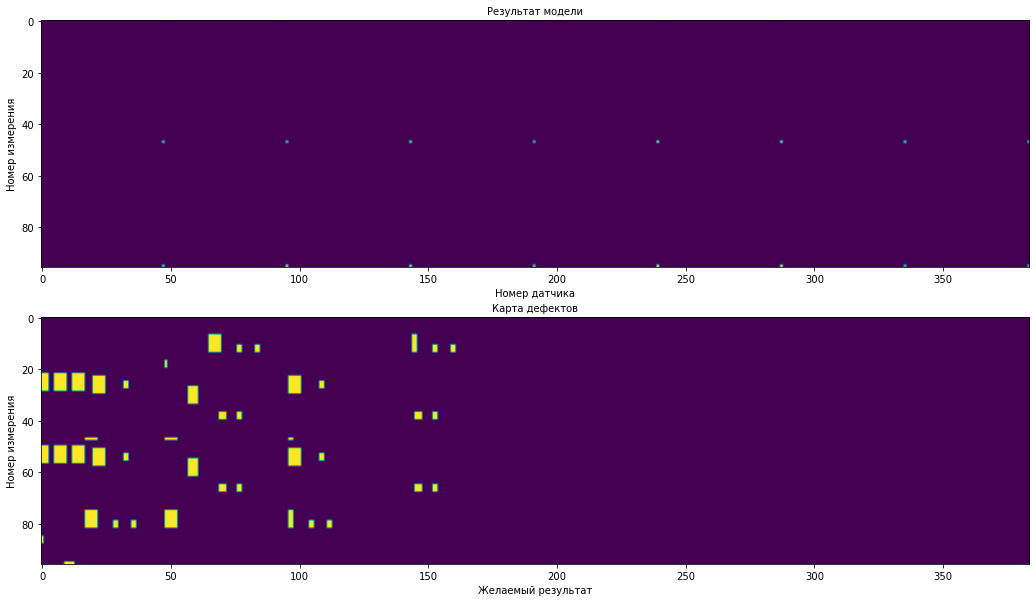

In [57]:
fig, axes = plt.subplots(2)

fig.set_figwidth(20)
fig.set_figheight(10)

axes[0].imshow(Y_res_map)

axes[0].set_xlabel('Номер датчика', fontsize=10) 
axes[0].set_ylabel('Номер измерения', fontsize=10) 
axes[0].set_title('Результат модели', fontsize=10) 

axes[1].imshow(Y_orig_map)

axes[1].set_xlabel('Желаемый результат', fontsize=10) 
axes[1].set_ylabel('Номер измерения', fontsize=10) 
axes[1].set_title('Карта дефектов', fontsize=10) 

     
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.8)
plt.show()

In [58]:
res = model.predict(X_dict['run2']['X_time_all'])
Y_res_map = reshape_3D_Y_numpy_to_2D(res,Y_dict['run2']['df'].shape[0],Y_dict['run2']['df'].shape[1],PREP_image_size)
Y_orig_map = reshape_3D_Y_numpy_to_2D(Y_dict['run2']['Y_all'],Y_dict['run2']['df'].shape[0],Y_dict['run2']['df'].shape[1],PREP_image_size)

||||||||||||||||||
Y arr reshaping to 2D
Original arr size:  (72, 48, 48, 1)
Crop windows height/width:  48
New numpy shape:  (96, 384, 1)
||||||||||||||||||

||||||||||||||||||
Y arr reshaping to 2D
Original arr size:  (72, 48, 48, 1)
Crop windows height/width:  48
New numpy shape:  (96, 384, 1)
||||||||||||||||||



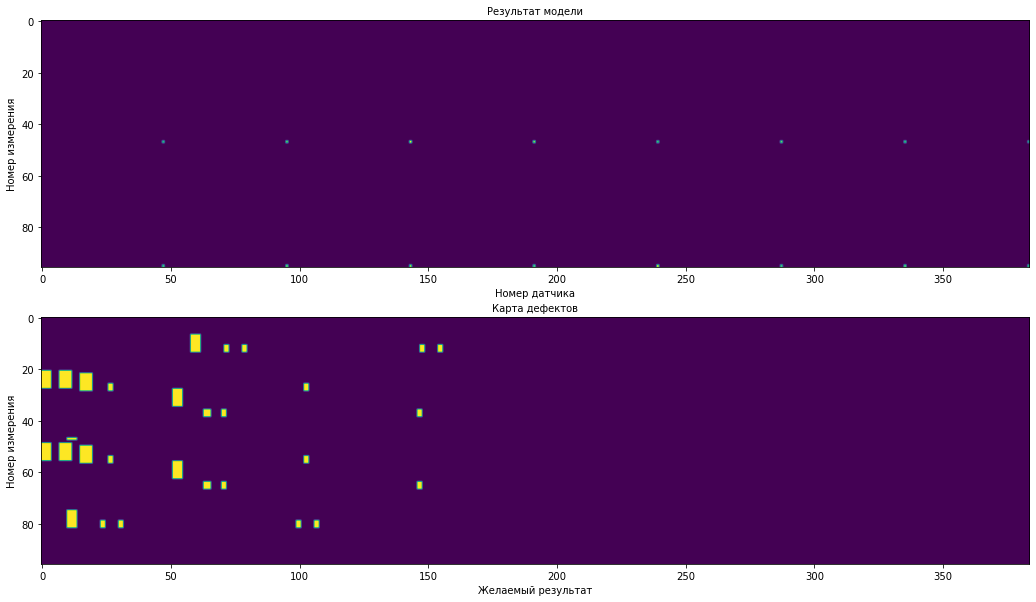

In [59]:
fig, axes = plt.subplots(2)

fig.set_figwidth(20)
fig.set_figheight(10)

axes[0].imshow(Y_res_map)

axes[0].set_xlabel('Номер датчика', fontsize=10) 
axes[0].set_ylabel('Номер измерения', fontsize=10) 
axes[0].set_title('Результат модели', fontsize=10) 

axes[1].imshow(Y_orig_map)

axes[1].set_xlabel('Желаемый результат', fontsize=10) 
axes[1].set_ylabel('Номер измерения', fontsize=10) 
axes[1].set_title('Карта дефектов', fontsize=10) 

     
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.8)
plt.show()